# 4. Using the Iterative Targeted Fast Gradient Sign Attack to Generate Attack Samples

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Pillow (tested on v9.3.0)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms

In [2]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the MNIST dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Dataset and Dataloader

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds = datasets.MNIST('./data', train = False, download = True, transform = tf)
test_loader = torch.utils.data.DataLoader(ds, batch_size = 1, shuffle = True)

### Loading a pre-trained model

As in previous notebooks.

In [5]:
# Model definition
class Net(nn.Module):
    """
    This is a basic Neural Net for MNIST
    - Two convolutions, into ReLU activations and dropouts after ReLU,
    - Flattening,
    - Fully connected, into ReLU activation and dropout after ReLU,
    - Fully connected, into Log-Softmax.
    """
    
    def __init__(self):
        super(Net, self).__init__()
        # Conv. 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        # Conv. 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        # Dropout for Conv. layers
        self.conv2_drop = nn.Dropout2d()
        # FC 1
        self.fc1 = nn.Linear(320, 50)
        # FC 2
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Conv. 1 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv. 2 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten
        x = x.view(-1, 320)
        # FC 1 + ReLU + Droupout 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        # FC 2 + Log-Softmax
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [6]:
# Load the pretrained model
model = Net()
pretrained_model = "./mnist_model.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# Set the model in evaluation mode
# (Important, because we have dropout layers!)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Iterative Targeted Fast Gradient Sign Method (ITFGSM) attack function

This time we make the FGSM attack iterated (will run for a certain number of iterations or whenever we manage to produce a valid attack sample, whichever comes first).

We will also make it targeted, by using a gradient descent with respect to a target class (not the original ground truth label). 

To demonstrate, the target class will be class 8.

In [8]:
def itfgsm_attack(image, epsilon, model, orig_class, target_class, device, iter_num = 10):
    
    # Skip if epsilon is 0
    if epsilon == 0:
        return image, False, 0
    worked = False
    
    for i in range(iter_num):
        # Zero out previous gradients
        image.grad = None
        # Forward pass
        out = model(image)
        # Calculate loss
        pred_loss = F.nll_loss(out, target_class)
        
        # Do backward pass and retain graph
        #pred_loss.backward()
        pred_loss.backward(retain_graph = True)
        
        # Add noise to processed image
        eps_image = image - epsilon*torch.sign(image.grad.data)
        eps_image.retain_grad()
        
        # Clipping eps_image to maintain pixel values into the [0, 1] range
        eps_image = torch.clamp(eps_image, 0, 1)
        
        # Forward pass
        new_output = model(eps_image)
        # Get prediction
        _, new_label = new_output.data.max(1)
        
        # Check if the new_label matches target, if so stop
        if new_label == target_class:
            worked = True
            break
        else:
            image = eps_image
            image.retain_grad()
            
    return eps_image, worked, i

### Testing ITFGSM attacks on our model

Minor changes to account for the fact that the attack method is now iterated and targeted.

As shown in class.

In [9]:
def test(model, device, test_loader, epsilon):
    
    # Target class
    target_class = torch.tensor([8]).to(device)

    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for i, (image, label) in enumerate(test_loader):
        
        # Display
        if (i%250 == 0):
            print("Batch {} / {}".format(i, len(test_loader)))
        
        # If the initial label is already matching the target class,
        # do not bother attacking, skip current image
        if target_class.item() == label.item():
            correct_counter += 1
            continue
        
        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the ugm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        init_pred = output.max(1, keepdim = True)[1]

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue

        # Call TFGSM Attack
        eps_image, worked, iterations = itfgsm_attack(image, epsilon, model, label, target_class, device)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        eps_pred = output2.max(1, keepdim = True)[1]

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if not worked:
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Test Accuracy = {}/{} = {}".format(epsilon, \
                                                            correct_counter, \
                                                            len(test_loader), \
                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [10]:
epsilons = [0, .005, .01, .015, .02, .025, .03, 0.05, 0.1]
accuracies = []
examples = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Batch 0 / 10000
Batch 250 / 10000
Batch 500 / 10000
Batch 750 / 10000
Batch 1000 / 10000
Batch 1250 / 10000
Batch 1500 / 10000
Batch 1750 / 10000
Batch 2000 / 10000
Batch 2250 / 10000
Batch 2500 / 10000
Batch 2750 / 10000
Batch 3000 / 10000
Batch 3250 / 10000
Batch 3500 / 10000
Batch 3750 / 10000
Batch 4000 / 10000
Batch 4250 / 10000
Batch 4500 / 10000
Batch 4750 / 10000
Batch 5000 / 10000
Batch 5250 / 10000
Batch 5500 / 10000
Batch 5750 / 10000
Batch 6000 / 10000
Batch 6250 / 10000
Batch 6500 / 10000
Batch 6750 / 10000
Batch 7000 / 10000
Batch 7250 / 10000
Batch 7500 / 10000
Batch 7750 / 10000
Batch 8000 / 10000
Batch 8250 / 10000
Batch 8500 / 10000
Batch 8750 / 10000
Batch 9000 / 10000
Batch 9250 / 10000
Batch 9500 / 10000
Batch 9750 / 10000
Epsilon: 0 - Test Accuracy = 9820/10000 = 0.982
Batch 0 / 10000
Batch 250 / 10000
Batch 500 / 10000
Batch 750 / 10000
Batch 1000 / 10000
Batch 1250 / 10000
Batch 1500 / 10000
Batch 1750 / 10000
Batch 2000 / 10000
Batch 2250 / 10000
Batch 2500 / 1

### Visualization (accuracies vs. epsilon values and adversarial samples)

As in previous notebooks.

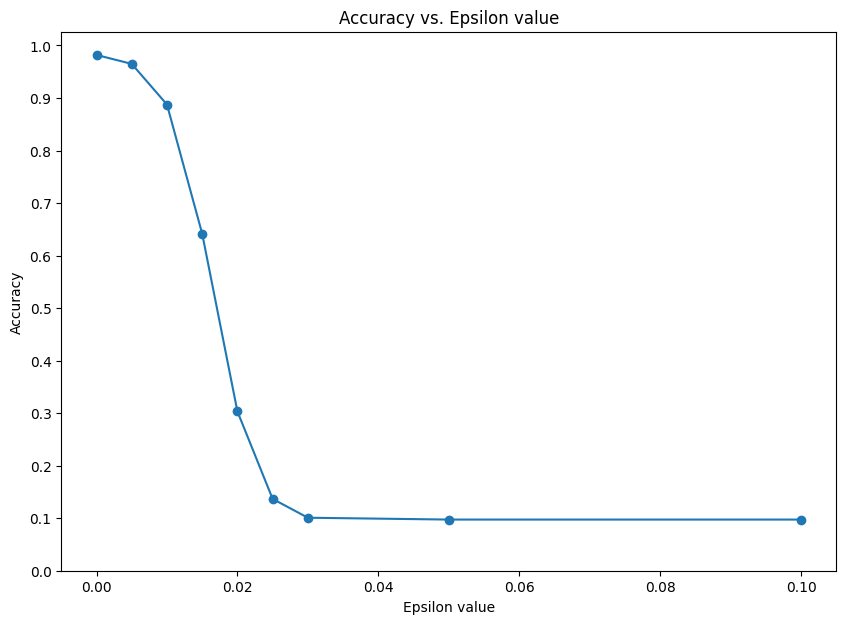

In [11]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

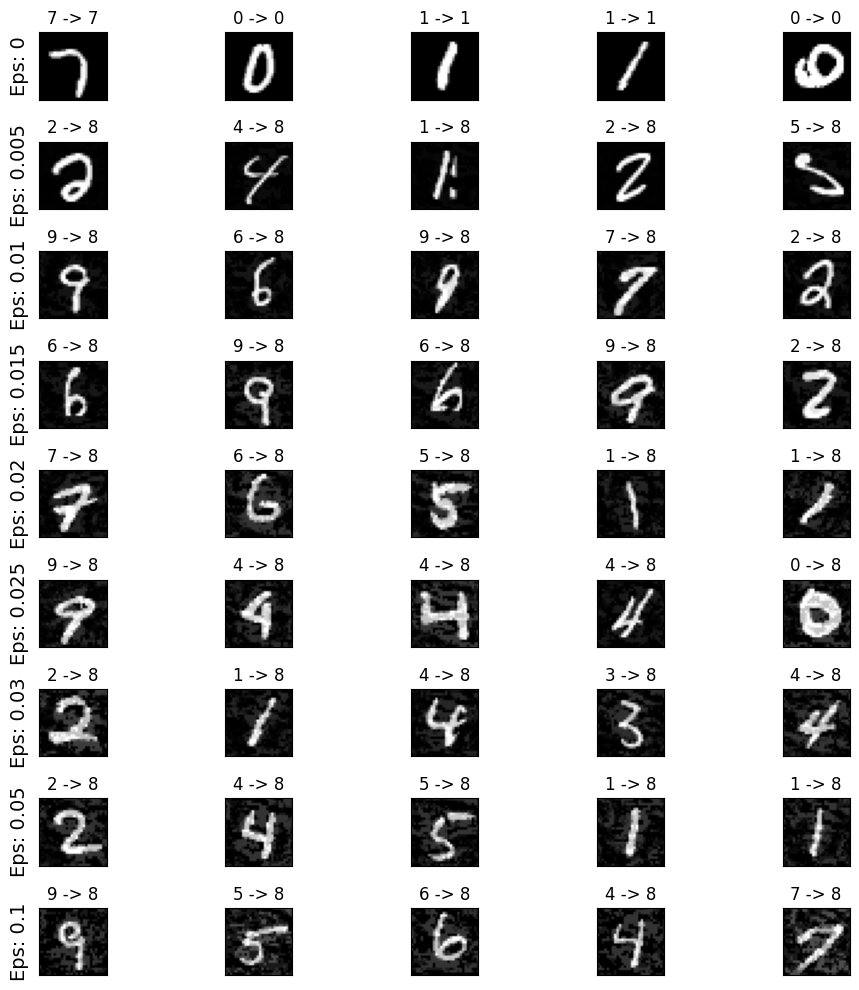

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()

### What's next?

In the next notebook, we will implement some defense mechanisms to try and prevent such attacks from working on our pre-trained model.